# Control System Design

## Linearização da planta

Para a aplicação de um controle no sistema é necessário a linearização das equações da dinâmica do satélite.

No contexto para pequenos ângulos a linearização se dá pela substituição de sin $\theta$ $\approx$ $\theta$ e cos $\theta$ $\approx$ 1,
tem-se portanto:

$\ddot{\phi}=\frac{1}{J_x}(\omega_o^2(J_z-J_y)\phi+\omega_o(J_x+J_z-J_y) \dot{\psi}+T_x)$

$\ddot{\theta}=\frac{T_y}{J_y}$

$\ddot{\psi}=\frac{1}{J_z}(-\omega_o^2(J_y-J_x)\psi-\omega_o(J_z-J_y+J_x) \dot{\phi}+T_z)$


/tmp/ipykernel_3010/2884635035.py:101: RuntimeWarning: overflow encountered in multiply
  w_rdr_y[i+1] = w_rdr_y[i]+dotw_rdr_y[i+1]*time[i+1]
/tmp/ipykernel_3010/2884635035.py:114: RuntimeWarning: overflow encountered in add
  theta[i+1] = theta[i]+dottheta[i+1]*time[i+1]
/tmp/ipykernel_3010/2884635035.py:101: RuntimeWarning: invalid value encountered in add
  w_rdr_y[i+1] = w_rdr_y[i]+dotw_rdr_y[i+1]*time[i+1]
/tmp/ipykernel_3010/2884635035.py:114: RuntimeWarning: overflow encountered in multiply
  theta[i+1] = theta[i]+dottheta[i+1]*time[i+1]
/tmp/ipykernel_3010/2884635035.py:114: RuntimeWarning: invalid value encountered in add
  theta[i+1] = theta[i]+dottheta[i+1]*time[i+1]
/tmp/ipykernel_3010/2884635035.py:94: RuntimeWarning: invalid value encountered in add
  dotw_rdr_y[i+1] = dotw_rdr_y[i]+K_dtheta*dottheta[i]+dotw_rdr_y[i]+K_theta*theta[i]


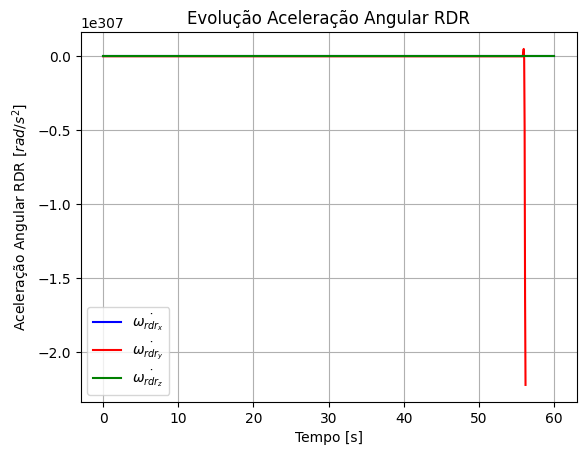

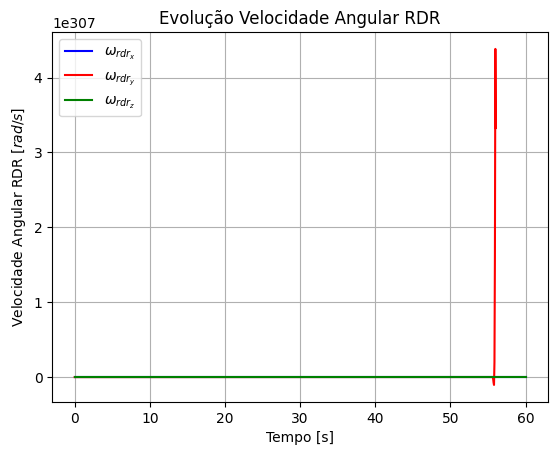

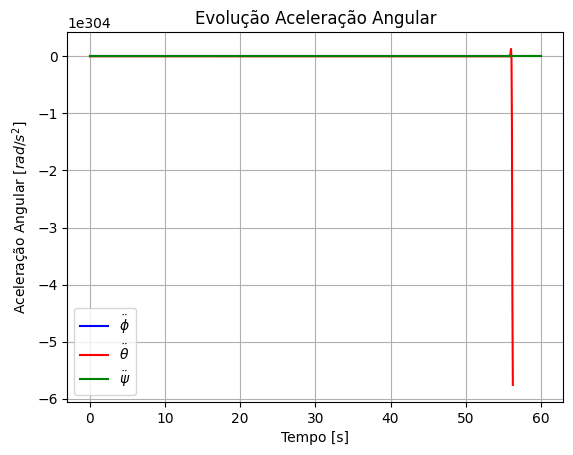

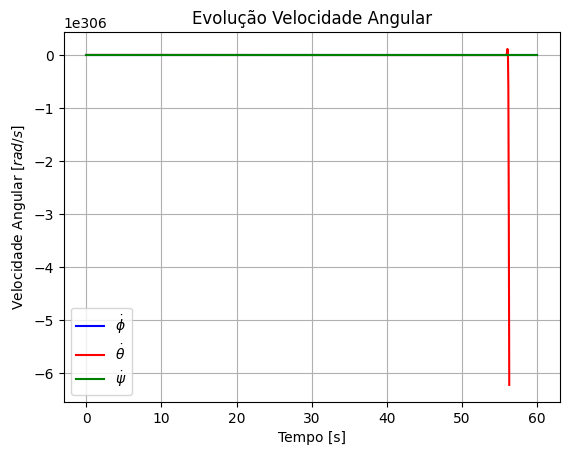

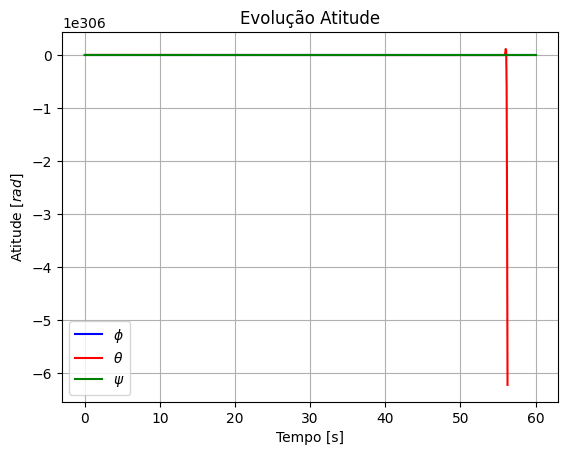

In [1]:
import matplotlib.pyplot as plt
from numpy import pi
import numpy as np

mu_Terra = 3.98600441e+014

def osv2eko(r_SCGI, v_SCGI):
    global mu_Terra
    # versores sistema de coordenadas inercial centrado na terra J2000
    vec_k = np.array([0, 0, 1])
    vec_i = np.array([1, 0, 0])
    # Elementos orbitais clássicos
    h = np.cross(r_SCGI, v_SCGI) # [m**2/s]
    p = np.dot(h, h)/mu_Terra # [m]
    B = np.cross(v_SCGI,h) - mu_Terra * r_SCGI / np.linalg.norm(r_SCGI) # [m^3/s**2]
    e = B/mu_Terra
    a = p/(1-np.dot(e, e)) # [m]
    vec_N = np.cross(vec_k, h) # [m**2/s]
    i = np.arccos(np.dot(vec_k, h)/np.linalg.norm(h))
    RAAN = np.arccos(np.dot(vec_i, vec_N)/np.linalg.norm(vec_N)) # [rad]
    omega = np.arccos(np.dot(e, vec_N)/(np.linalg.norm(e)*np.linalg.norm(vec_N))) # [rad]
    f = np.real(np.arccos(np.dot(r_SCGI, e)/(np.linalg.norm(e)*np.linalg.norm(r_SCGI)))) # [rad]
    return  [a, e, i, RAAN, omega, f]


r_SCGI = np.array([2.25526213722520e+006, -3.00492371279401e+006, -5.84397331427593e+006]) # m
v_SCGI = np.array([-5.19923341417592e+003, 3.82519438208177e+003, -3.97333292224794e+003]) # m/s
[a, e, i, RAAN, omega, f] = osv2eko(r_SCGI, v_SCGI)


movimentoMedio = np.sqrt(mu_Terra/a**3) # [rad/s]
w_O_I_O = movimentoMedio

samples = 1000
time_o = 0
time_f = 60
time = np.linspace(time_o,time_f,samples)
phi = np.zeros((samples, 1))
theta = np.zeros((samples, 1))
psi = np.zeros((samples, 1))
dotphi = np.zeros((samples, 1))
dottheta = np.zeros((samples, 1))
dotpsi = np.zeros((samples, 1))
ddotphi = np.zeros((samples, 1))
ddottheta = np.zeros((samples, 1))
ddotpsi = np.zeros((samples, 1))
w_rdr_x = np.zeros((samples, 1))
w_rdr_y = np.zeros((samples, 1))
w_rdr_z = np.zeros((samples, 1))
dotw_rdr_x = np.zeros((samples, 1))
dotw_rdr_y = np.zeros((samples, 1))
dotw_rdr_z = np.zeros((samples, 1))
T_x = np.zeros((samples, 1))
T_y = np.zeros((samples, 1))
T_z = np.zeros((samples, 1))

phi[0] = np.deg2rad(0)
theta[0] = np.deg2rad(0)
psi[0] = np.deg2rad(0)

dotphi[0] = np.deg2rad(0.1)
dottheta[0] = np.deg2rad(0.1)
dotpsi[0] = np.deg2rad(0.1)

# For a CubeSat 6U
cubeSatMass = 6 #  [kg] 
cubeSatLength = 0.1 # [m] -> x
cubeSatWidth = 0.2 # [m] -> y
cubeSatHeight = 0.3 # [m] -> z

Ixx = 1 /12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Iyy = 1 / 12 * cubeSatMass * ((cubeSatLength ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Izz = 1 / 12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatLength ** 2)) # slug * ft ^ 2

# For a RDR
m_rdr = 0.137 # [kg]
r_rdr = 0.0435 # [m]
I_rdr = 0.5*m_rdr*r_rdr**2 # [kg*m²]

K_dphi = -0.2822
K_dtheta = -0.2822
K_dpsi = -10.4
K_phi = -0.5
K_theta = -0.5
K_psi = -10.4


for i in range(len(time)-1):    
    # Controle

    dotw_rdr_x[i+1] = dotw_rdr_x[i]+K_dphi*dotphi[i]+dotw_rdr_x[i]+K_phi*phi[i]
    T_x[i+1] = I_rdr*dotw_rdr_x[i+1]

    dotw_rdr_y[i+1] = dotw_rdr_y[i]+K_dtheta*dottheta[i]+dotw_rdr_y[i]+K_theta*theta[i]
    T_y[i+1] = I_rdr*dotw_rdr_y[i+1]

    dotw_rdr_z[i+1] = dotw_rdr_z[i]+K_dpsi*dotpsi[i]+dotw_rdr_z[i]+K_psi*psi[i]
    T_z[i+1] = I_rdr*dotw_rdr_z[i+1]

    w_rdr_x[i+1] = w_rdr_x[i]+dotw_rdr_x[i+1]*time[i+1]      
    w_rdr_y[i+1] = w_rdr_y[i]+dotw_rdr_y[i+1]*time[i+1]      
    w_rdr_z[i+1] = w_rdr_z[i]+dotw_rdr_z[i+1]*time[i+1]  

    # Planta
    ddotphi[i+1] = 1/Ixx*(w_O_I_O**2*(Izz-Iyy)*phi[i]+w_O_I_O*(Ixx+Izz-Iyy)*psi[i]+T_x[i+1])
    ddottheta[i+1] = T_y[i]/Iyy
    ddotpsi[i+1] = 1/Izz*(-w_O_I_O**2*(Iyy-Ixx)*psi[i]-w_O_I_O*(Izz-Iyy+Ixx)*dotphi[i]+T_z[i+1])

    dotphi[i+1] = dotphi[i]+ddotphi[i+1]*time[i+1] 
    dottheta[i+1] = dottheta[i]+ddottheta[i+1]*time[i+1] 
    dotpsi[i+1] = dotpsi[i]+dotpsi[i+1]*time[i+1]

    phi[i+1] = phi[i]+dotphi[i+1]*time[i+1] 
    theta[i+1] = theta[i]+dottheta[i+1]*time[i+1] 
    psi[i+1] = psi[i]+psi[i+1]*time[i+1] 



plt.figure()
plt.title('Evolução Aceleração Angular RDR')
plt.plot(time,dotw_rdr_x,'b',label=r'$\dot{\omega_{rdr_x}}$')
plt.plot(time,dotw_rdr_y,'r',label=r'$\dot{\omega_{rdr_y}}$')
plt.plot(time,dotw_rdr_z,'g',label=r'$\dot{\omega_{rdr_z}}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Aceleração Angular RDR [$rad/s^2$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Velocidade Angular RDR')
plt.plot(time,w_rdr_x,'b',label=r'$\omega_{rdr_x}$')
plt.plot(time,w_rdr_y,'r',label=r'$\omega_{rdr_y}$')
plt.plot(time,w_rdr_z,'g',label=r'$\omega_{rdr_z}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Velocidade Angular RDR [$rad/s$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)


# Resultado Torque por Velocidade de Rotação
plt.figure()
plt.title('Evolução Aceleração Angular')
plt.plot(time,ddotphi,'b',label=r'$\ddot{\phi}$')
plt.plot(time,ddottheta,'r',label=r'$\ddot{\theta}$')
plt.plot(time,ddotpsi,'g',label=r'$\ddot{\psi}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Aceleração Angular [$rad/s^2$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Velocidade Angular')
plt.plot(time,dotphi,'b',label=r'$\dot{\phi}$')
plt.plot(time,dottheta,'r',label=r'$\dot{\theta}$')
plt.plot(time,dotpsi,'g',label=r'$\dot{\psi}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Velocidade Angular [$rad/s$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Atitude')
plt.plot(time,phi,'b',label=r'$\phi$')
plt.plot(time,dottheta,'r',label=r'$\theta$')
plt.plot(time,psi,'g',label=r'$\psi$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Atitude [$rad$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.grid(True)
plt.legend()


plt.show()

### Em espaço de estados teria-se:

- Meu vetor de estados é:

$X = [\phi, \: \theta, \: \psi, \: \dot{\phi}, \: \dot{\theta}, \: \dot{\psi}]^T$

- Por sua vez a derivada do meu vetor de estados fica:

$\dot{X} = [\dot{\phi}, \: \dot{\theta}, \: \dot{\psi}, \: \ddot{\phi}, \: \ddot{\theta}, \: \ddot{\psi}]^T$

- Meu vetor de controle:

$U = [\dot{\omega_{rdr_x}}, \:,\dot{\omega_{rdr_y}} \:, \dot{\omega_{rdr_z}}]^T$

Sendo a equação fundamental:

$
A = \begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\frac{1}{J_x}*(\omega_o^2(J_z-J_y)) & 0 & 0 & 0 & 0 & \frac{1}{J_x}*(\omega_o(J_x+J_z-J_y)) \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \frac{1}{J_z}*(-\omega_o^2(J_y-J_x)) & \frac{1}{J_z}*(-\omega_o(J_z-J_y+J_x)) & 0 & 0
\end{bmatrix}
$

$
B = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\frac{1}{J_{rdr}} & 0 & 0 \\
0 & \frac{1}{J_{rdr}} & 0 \\
0 & 0 & \frac{1}{J_{rdr}} \\
\end{bmatrix}
$

$\dot{X} = A\:X+B\:U$

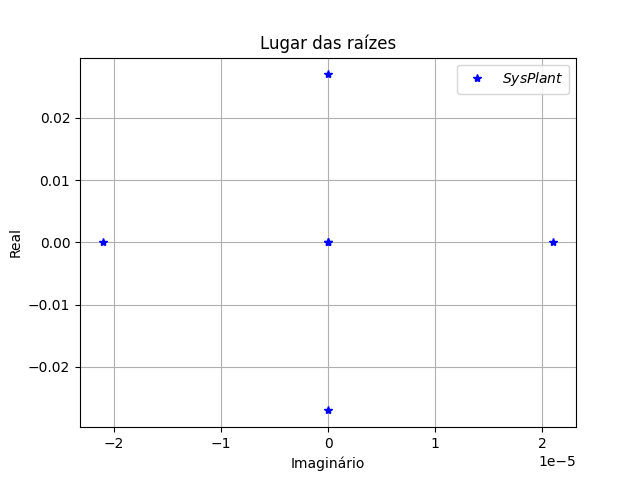

In [2]:
import control
%matplotlib widget

states = ['phi', 'theta', 'psi', 'dotphi', 'dottheta', 'dotpsi']
inputs = ['dotomega_rdr_x', 'dotomega_rdr_y', 'dotomega_rdr_z']

A_Plant = np.array([
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 1],
[1/Ixx*w_O_I_O**2*(Izz-Iyy), 0, 0, 0, 0, 1/Ixx*w_O_I_O*(Ixx+Izz-Iyy)],
[0, 0, 0, 0, 0, 0],
[0, 0, 1/Izz*-w_O_I_O**2*(Iyy-Ixx), 1/Izz*-w_O_I_O/(Izz-Iyy+Ixx),0,0]
])

B_Plant = np.array([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[I_rdr/Ixx, 0, 0],
[0, I_rdr/Iyy, 0],
[0, 0, I_rdr/Izz],
])

num_inputs  = B_Plant.shape[1]
num_outputs = A_Plant.shape[0]
C_Plant = np.eye(num_outputs)
D__Plant = np.zeros([num_outputs,num_inputs])

sys_Plant = control.StateSpace(A_Plant,B_Plant,C_Plant,D__Plant)

plt.figure()
plt.title("Lugar das raízes")
poles_Plant = sys_Plant.poles()
plt.plot(poles_Plant.real, poles_Plant.imag, 'b*', label=r'$Sys Plant$')
plt.legend()
plt.xlabel("Imaginário")
plt.ylabel("Real")
plt.grid(True)
plt.show()



## Projeto de Controlador

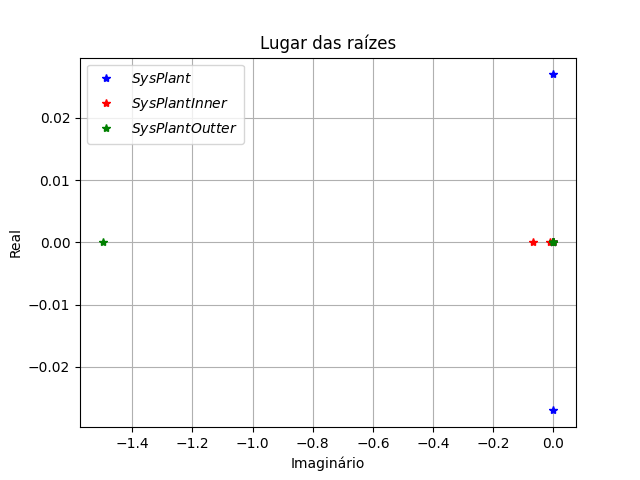

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


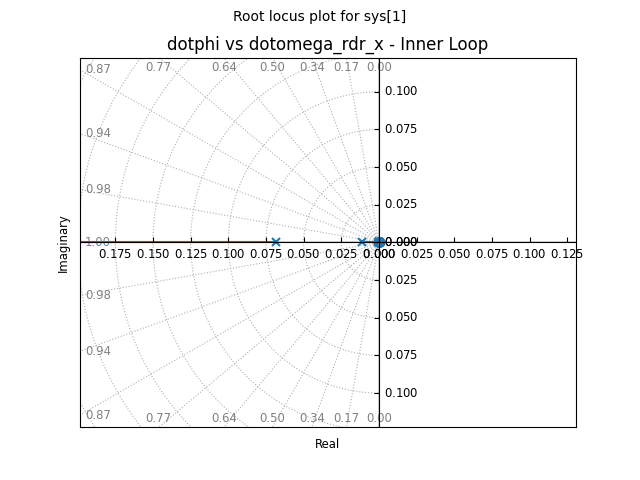

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


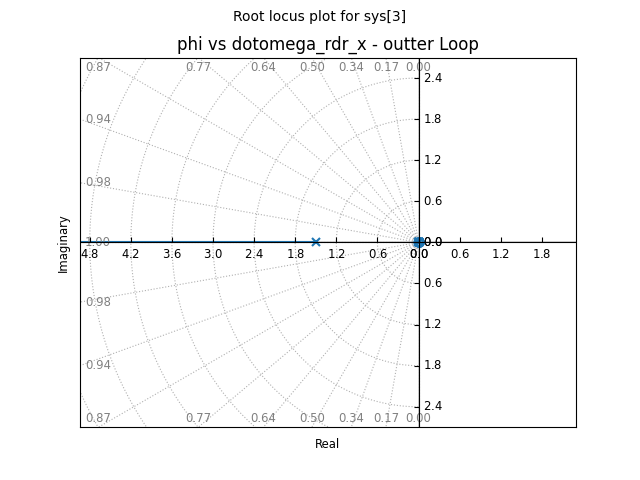

In [3]:
# Phi dotphi
# Inner loop

selected_state= 'dotphi'
selected_input = 'dotomega_rdr_x'

input_index = inputs.index(selected_input)
state_index = states.index(selected_state)
B_rdr_x =  B_Plant[:,input_index:input_index+1]

K_inner = 0.2822

K = np.zeros([1,num_outputs])
K[0][state_index] = K_inner
A_inner = A_Plant - K*K_inner
C_inner = C_Plant[state_index,:]

sys_inner = control.StateSpace(A_inner, B_rdr_x, C_inner, 0)
plt.figure()
control.root_locus(sys_inner)
plt.title("dotphi vs dotomega_rdr_x - Inner Loop")
plt.xlabel("Real")
plt.ylabel("Imaginary")

# Outer loop
selected_state= 'phi'
selected_input = 'dotomega_rdr_x'

K_outter = 0.5
K = np.zeros([1,num_outputs])
K[0][state_index] = K_outter
A_outter = A_Plant - K*state_index
C_outter = C_Plant[state_index,:]

sys_outter = control.StateSpace(A_outter, B_rdr_x, C_outter, 0)
plt.figure()
control.root_locus(sys_outter)
plt.title("phi vs dotomega_rdr_x - outter Loop")
plt.xlabel("Real")
plt.ylabel("Imaginary")

plt.figure()
plt.title("Lugar das raízes")
poles_Plant = sys_Plant.poles()
poles_inner= sys_inner.poles()
poles_outter= sys_outter.poles()
plt.plot(poles_Plant.real, poles_Plant.imag, 'b*', label=r'$Sys Plant$')
plt.plot(poles_inner.real, poles_inner.imag, 'r*', label=r'$Sys Plant Inner$')
plt.plot(poles_outter.real, poles_outter.imag, 'g*', label=r'$Sys Plant Outter$')
plt.legend()
plt.xlabel("Imaginário")
plt.ylabel("Real")
plt.grid(True)
plt.show()


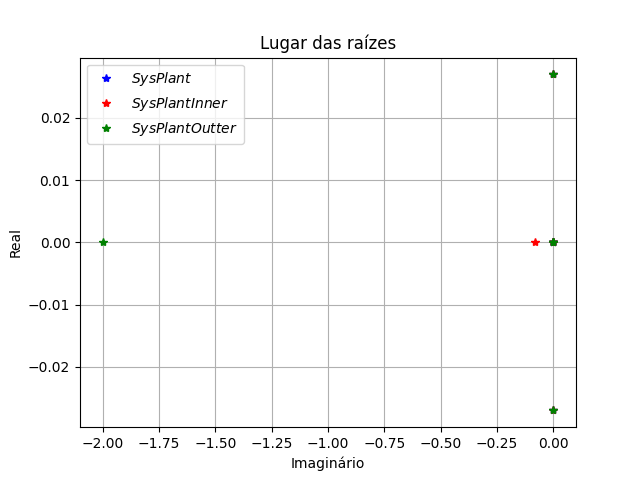

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


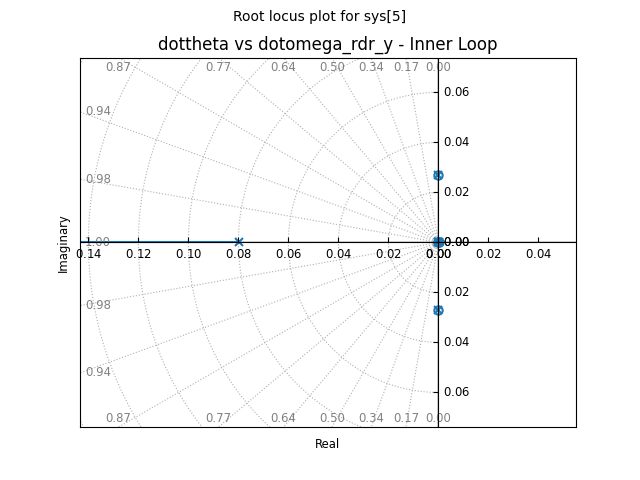

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


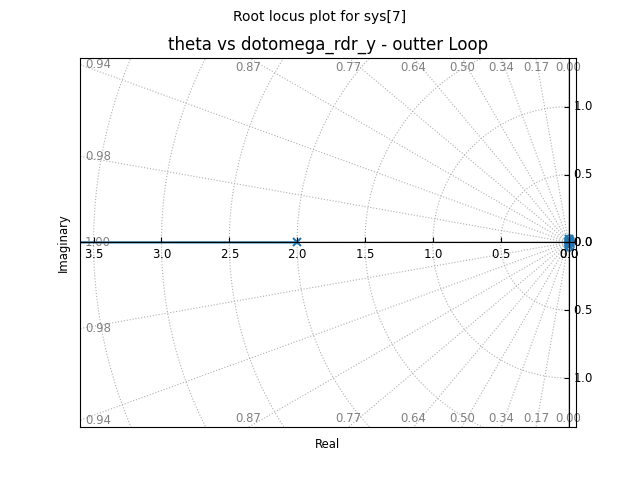

In [4]:
# Theta e dotheta
# Inner loop

selected_state= 'dottheta'
selected_input = 'dotomega_rdr_y'

input_index = inputs.index(selected_input)
state_index = states.index(selected_state)
B_rdr_x =  B_Plant[:,input_index:input_index+1]

K_inner = 0.2822

K = np.zeros([1,num_outputs])
K[0][state_index] = K_inner
A_inner = A_Plant - K*K_inner
C_inner = C_Plant[state_index,:]

sys_inner = control.StateSpace(A_inner, B_rdr_x, C_inner, 0)
plt.figure()
control.root_locus(sys_inner)
plt.title("dottheta vs dotomega_rdr_y - Inner Loop")
plt.xlabel("Real")
plt.ylabel("Imaginary")

# Outer loop
selected_state= 'theta'
selected_input = 'dotomega_rdr_y'

K_outter = 0.5
K = np.zeros([1,num_outputs])
K[0][state_index] = K_outter
A_outter = A_Plant - K*state_index
C_outter = C_Plant[state_index,:]

sys_outter = control.StateSpace(A_outter, B_rdr_x, C_outter, 0)
plt.figure()
control.root_locus(sys_outter)
plt.title("theta vs dotomega_rdr_y - outter Loop")
plt.xlabel("Real")
plt.ylabel("Imaginary")

plt.figure()
plt.title("Lugar das raízes")
poles_Plant = sys_Plant.poles()
poles_inner= sys_inner.poles()
poles_outter= sys_outter.poles()
plt.plot(poles_Plant.real, poles_Plant.imag, 'b*', label=r'$Sys Plant$')
plt.plot(poles_inner.real, poles_inner.imag, 'r*', label=r'$Sys Plant Inner$')
plt.plot(poles_outter.real, poles_outter.imag, 'g*', label=r'$Sys Plant Outter$')
plt.legend()
plt.xlabel("Imaginário")
plt.ylabel("Real")
plt.grid(True)
plt.show()

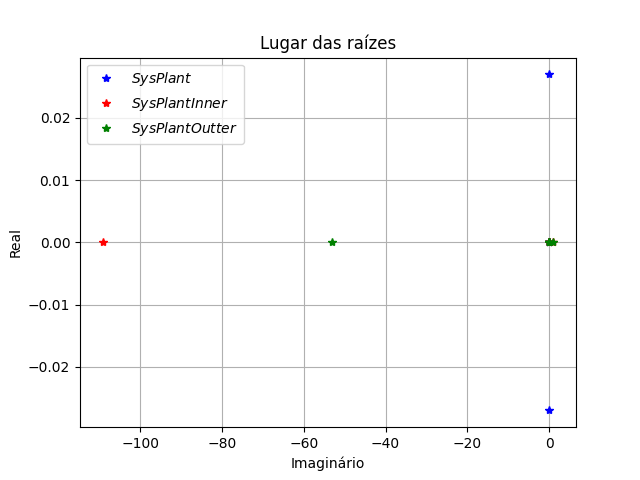

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


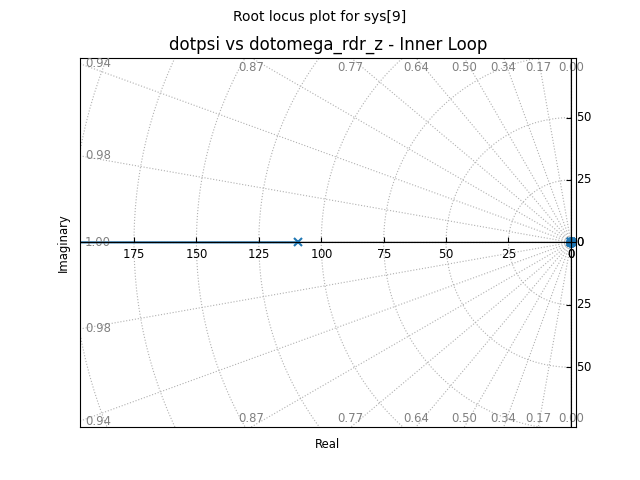

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


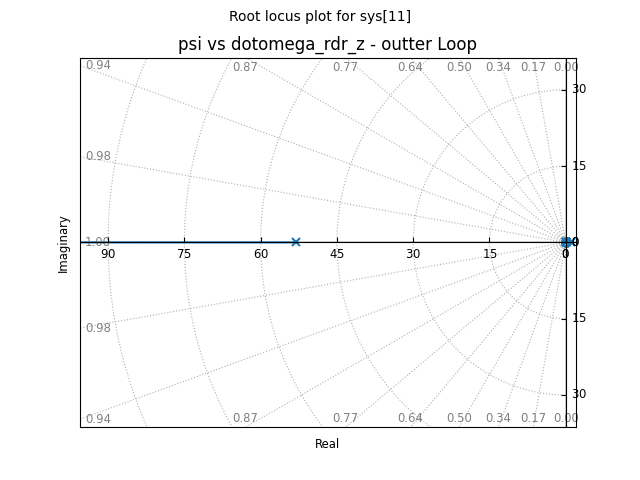

In [5]:
# Psi dotpsi
# Inner loop

selected_state= 'dotpsi'
selected_input = 'dotomega_rdr_z'

input_index = inputs.index(selected_input)
state_index = states.index(selected_state)
B_rdr_x =  B_Plant[:,input_index:input_index+1]

K_inner = 10.4

K = np.zeros([1,num_outputs])
K[0][state_index] = K_inner
A_inner = A_Plant - K*K_inner
C_inner = C_Plant[state_index,:]

sys_inner = control.StateSpace(A_inner, B_rdr_x, C_inner, 0)
plt.figure()
control.root_locus(sys_inner)
plt.title("dotpsi vs dotomega_rdr_z - Inner Loop")
plt.xlabel("Real")
plt.ylabel("Imaginary")

# Outer loop
selected_state= 'psi'
selected_input = 'dotomega_rdr_z'

K_outter = 10.4
K = np.zeros([1,num_outputs])
K[0][state_index] = K_outter
A_outter = A_Plant - K*state_index
C_outter = C_Plant[state_index,:]

sys_outter = control.StateSpace(A_outter, B_rdr_x, C_outter, 0)
plt.figure()
control.root_locus(sys_outter)
plt.title("psi vs dotomega_rdr_z - outter Loop")
plt.xlabel("Real")
plt.ylabel("Imaginary")

plt.figure()
plt.title("Lugar das raízes")
poles_Plant = sys_Plant.poles()
poles_inner= sys_inner.poles()
poles_outter= sys_outter.poles()
plt.plot(poles_Plant.real, poles_Plant.imag, 'b*', label=r'$Sys Plant$')
plt.plot(poles_inner.real, poles_inner.imag, 'r*', label=r'$Sys Plant Inner$')
plt.plot(poles_outter.real, poles_outter.imag, 'g*', label=r'$Sys Plant Outter$')
plt.legend()
plt.xlabel("Imaginário")
plt.ylabel("Real")
plt.grid(True)
plt.show()
